Table of Contents: 

* [Normalized protein percentages for SPP and NAT](#section-one)
* [Second Anchor](#section-two)
* [Third Anchor](#section-three)
* [Fourth Anchor](#section-four)
* [Fifth Anchor](#section-five)
* [Sixth Anchor](#section-six)

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


data = pd.read_excel('Malaria_Research_Data.xlsx', header=0)
total_spectra = data.groupby('Biological sample category')['Protein percentage of total spectra'].sum()

# Normalize the protein percentages within each group
data['Normalized protein percentage'] = data.groupby('Biological sample category')['Protein percentage of total spectra'].transform(lambda x: (x / x.sum()) * 100)

# Calculate the corrected normalized protein percentage
data['Corrected normalized protein percentage'] = data.groupby('Biological sample category')['Normalized protein percentage'].transform(lambda x: (x / x.sum()) * 100)

print(data)

                                  Experiment name Biological sample category   
0        SPP vs. NAT coIP results recieved 1.9.23                        NAT  \
1        SPP vs. NAT coIP results recieved 1.9.23                        NAT   
2        SPP vs. NAT coIP results recieved 1.9.23                        NAT   
3        SPP vs. NAT coIP results recieved 1.9.23                        NAT   
4        SPP vs. NAT coIP results recieved 1.9.23                        NAT   
...                                           ...                        ...   
19259  SPP vs. NAT coIP results recieved 11.15.22                        SPP   
19260  SPP vs. NAT coIP results recieved 11.15.22                        SPP   
19261  SPP vs. NAT coIP results recieved 11.15.22                        SPP   
19262  SPP vs. NAT coIP results recieved 11.15.22                        SPP   
19263  SPP vs. NAT coIP results recieved 11.15.22                        SPP   

                                       

<a id="section-one"></a>
## Normalized protein percentages for SPP and NAT

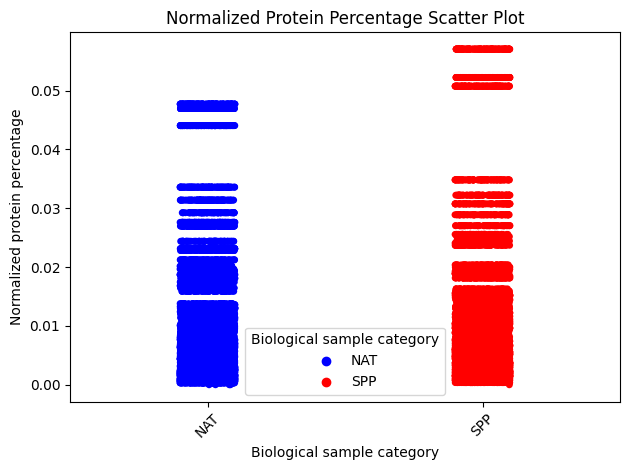

In [5]:
custom_colors = {'SPP': 'red', 'NAT': 'blue'}
sns.stripplot(data=data, x='Biological sample category', y='Normalized protein percentage', hue='Biological sample category', palette=custom_colors, jitter=True)
plt.title('Normalized Protein Percentage Scatter Plot')
plt.xlabel('Biological sample category')
plt.ylabel('Normalized protein percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
import scipy.stats as stats

# Filter proteins for SPP and NAT
spp_proteins = data[data['Biological sample category'] == 'SPP']
nat_proteins = data[data['Biological sample category'] == 'NAT']

# Check normality assumption using Shapiro-Wilk test
shapiro_spp = stats.shapiro(spp_proteins['Normalized protein percentage'])
shapiro_nat = stats.shapiro(nat_proteins['Normalized protein percentage'])

# Perform Shapiro-Wilk test and print the results
print(f"Shapiro-Wilk test results:")
print(f"SPP - p-value: {shapiro_spp.pvalue}")
print(f"NAT - p-value: {shapiro_nat.pvalue}")

# Check normality assumption using Anderson-Darling test
anderson_spp = stats.anderson(spp_proteins['Normalized protein percentage'])
anderson_nat = stats.anderson(nat_proteins['Normalized protein percentage'])

# Perform Anderson-Darling test and print the results
print(f"Anderson-Darling test results:")
print(f"SPP - statistic: {anderson_spp.statistic}, critical values: {anderson_spp.critical_values}, p-values: {anderson_spp.significance_level}")
print(f"NAT - statistic: {anderson_nat.statistic}, critical values: {anderson_nat.critical_values}, p-values: {anderson_nat.significance_level}")

# Calculate the mean normalized protein percentage for SPP and NAT
spp_mean_percentage = spp_proteins['Normalized protein percentage'].mean()
nat_mean_percentage = nat_proteins['Normalized protein percentage'].mean()

# Perform the Mann-Whitney U test, compare the two groups and produce the U-statistic and p-value
u_stat, p_value = stats.mannwhitneyu(spp_proteins['Normalized protein percentage'], nat_proteins['Normalized protein percentage'])

num_tests = 1
alpha = 0.05  # Desired significance level

# Check if the p-value is significant
if p_value < alpha / num_tests:
    print("The difference in mean normalized protein percentages is statistically significant.")
else:
    print("The difference in mean normalized protein percentages is not statistically significant.")

# Compare the normalized protein perecentage of each protein with the mean 
#normalized protein perecentage of the NAT group
# This specific DataFrame includes only the proteins that have higher normalized protein percentage than the 
# mean normalized protein percentage of the NAT group
# the protein names with counts less than 28 did not meet the condition of being enriched in the SPP group
enriched_proteins = spp_proteins[spp_proteins['Normalized protein percentage'] > nat_mean_percentage]

# Group the filtered data by protein name and calculate counts
sorted_proteins = enriched_proteins['Protein name'].value_counts().reset_index(name='Count').rename(columns={'index': 'Protein name'})

# Create a contingency table
contingency_table = [[len(enriched_proteins), len(nat_proteins) - len(enriched_proteins)],
                     [len(spp_proteins) - len(enriched_proteins), len(nat_proteins)]]

# Perform Fisher's exact test
oddsratio, p_value = stats.fisher_exact(contingency_table)

# Print the results
print("Fisher's exact test results:")
print("Odds ratio: {oddsratio}")
print("p-value: {p_value}")

# Check if the p-value is significant
alpha = 0.05  # Desired significance level

if p_value < alpha:
    print("The difference in protein enrichment between SPP and NAT is statistically significant.")
else:
    print("The difference in protein enrichment between SPP and NAT is not statistically significant.")


# Create a list to store the unique GN names
unique_gn_list = []

# Print the count and names of the enriched proteins 
print(f"Number of proteins showing up more in SPP than in NAT: {len(sorted_proteins)}")
print("Protein names and their counts:")
for index, row in sorted_proteins.iterrows():
    protein_name = row['Protein name']
    count = row['Count']
    gn_index = protein_name.find('GN=')
    if gn_index != -1:
        gn_name = protein_name[gn_index+3:].split(' ')[0]
        unique_gn_list.append(gn_name)
        print("{}, Count: {}".format(gn_name, count))
    else:
        print("GN Name: Not found, Count: {}".format(count))


Shapiro-Wilk test results:
SPP - p-value: 0.0
NAT - p-value: 0.0
Anderson-Darling test results:
SPP - statistic: 759.2892569494543, critical values: [0.576 0.656 0.787 0.918 1.092], p-values: [15.  10.   5.   2.5  1. ]
NAT - statistic: 701.7789041742417, critical values: [0.576 0.656 0.787 0.918 1.092], p-values: [15.  10.   5.   2.5  1. ]
The difference in mean normalized protein percentages is statistically significant.
Fisher's exact test results:
Odds ratio: {oddsratio}
p-value: {p_value}
The difference in protein enrichment between SPP and NAT is statistically significant.
Number of proteins showing up more in SPP than in NAT: 52
Protein names and their counts:
PF3D7_1408600, Count: 200
PF3D7_0719600, Count: 167
PF3D7_0818900, Count: 137
PF3D7_1357000, Count: 120
PF3D7_0929400, Count: 117
PF3D7_1462800, Count: 105
PF3D7_1027300, Count: 94
PF3D7_1338200, Count: 84
PF3D7_1108700, Count: 81
PF3D7_0516200, Count: 78
PF3D7_0917900, Count: 73
PF3D7_0507100, Count: 69
PF3D7_0312800, Coun

<a id="section-one"></a>
## First Anchor

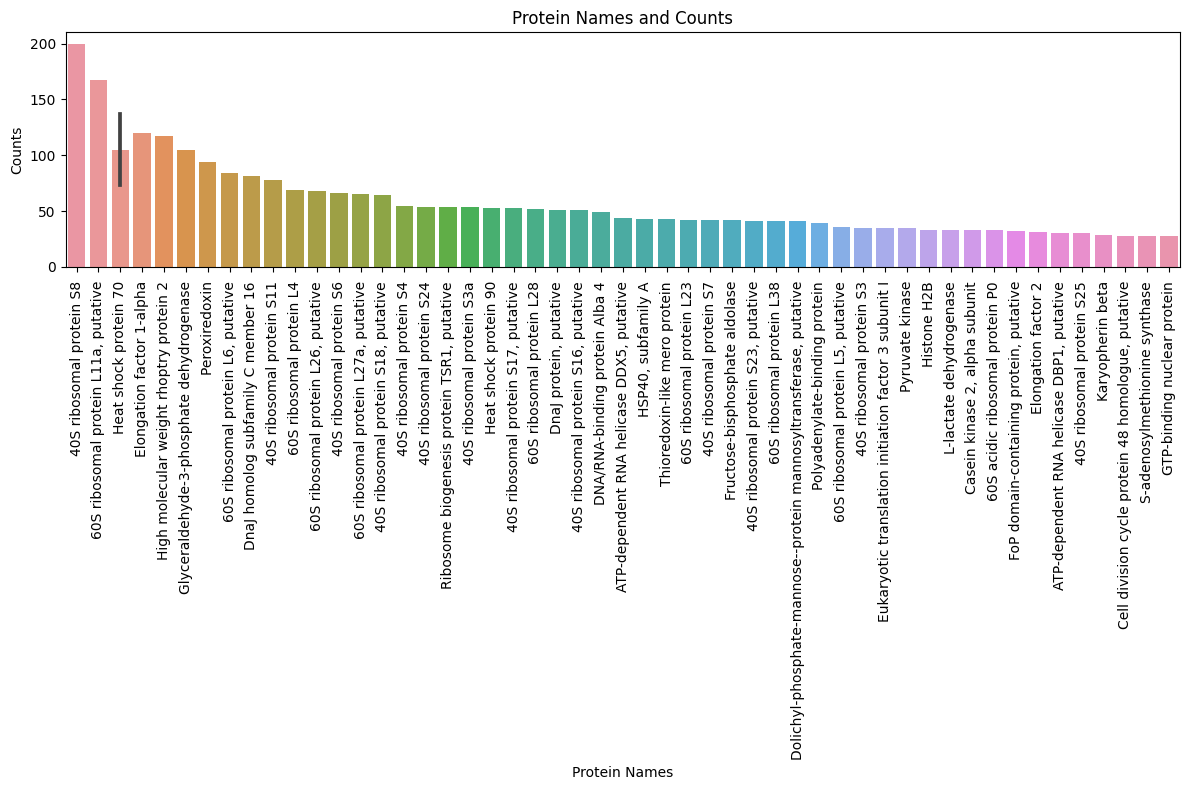

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a list to store the unique GN names
unique_protein_list = []

# Store protein names and counts
protein_names = []
counts = []

for index, row in sorted_proteins.iterrows():
    protein_name = row['Protein name']
    count = row['Count']
    os_index = protein_name.find('OS=')
    if os_index != -1:
        protein_name_short = protein_name[:os_index]
        unique_protein_list.append(protein_name_short)
        protein_names.append(protein_name_short)
        counts.append(count)

# Create a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=protein_names, y=counts)
plt.xticks(rotation=90)
plt.xlabel('Protein Names')
plt.ylabel('Counts')
plt.title('Protein Names and Counts')


plt.tight_layout()
plt.show()
